In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [3]:
from load_data.data_loader import load_df
df = load_df()
df.head()

,problem_class,problem_score,score_norm,combined_text,constraint,math,algoword,length
0,hard,2500.0,0.629630,Title: Digits Description: John gave Jack a ve...,5.301030,12,0,888
1,medium,2000.0,0.444444,Title: Neural Network country Description: Due...,2.025306,13,2,995
2,medium,2100.0,0.481481,Title: Property Description: Bill is a famous ...,4.698970,70,0,1292
3,medium,2100.0,0.481481,Title: Exploration plan Description: The compe...,4.301030,3,0,1253
4,medium,2100.0,0.481481,Title: Casinos and travel Description: John ha...,5.000000,4,2,1337


In [4]:
feature_cols = ["constraint", "math", "algoword", "length"]

In [5]:
le = LabelEncoder()
y = df["problem_class"]
y_encoded = le.fit_transform(y)

X_text = df["combined_text"]
X_num  = df[feature_cols].fillna(0)

(
    X_text_train, X_text_test,
    X_num_train,  X_num_test,
    y_train,  y_test,
) = train_test_split(
    X_text, X_num, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [6]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=3, max_df=0.9)

X_text_train_vec = tfidf.fit_transform(X_text_train)
X_text_test_vec  = tfidf.transform(X_text_test)


In [7]:
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled  = scaler.fit_transform(X_num_test)

X_train_final = hstack([X_text_train_vec, X_num_train_scaled])
X_test_final  = hstack([X_text_test_vec,  X_num_test_scaled])


In [8]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.05,
    objective='multi:softprob',
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

xgb_clf.fit(X_train_final, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = xgb_clf.predict(X_test_final)
print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred, digits=4))
print()
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5486311239193083

              precision    recall  f1-score   support

           0     0.6258    0.6972    0.6595       885
           1     0.5768    0.5939    0.5852       980
           2     0.4149    0.3557    0.3830       911

    accuracy                         0.5486      2776
   macro avg     0.5391    0.5489    0.5426      2776
weighted avg     0.5393    0.5486    0.5425      2776


[[617  96 172]
 [113 582 285]
 [256 331 324]]


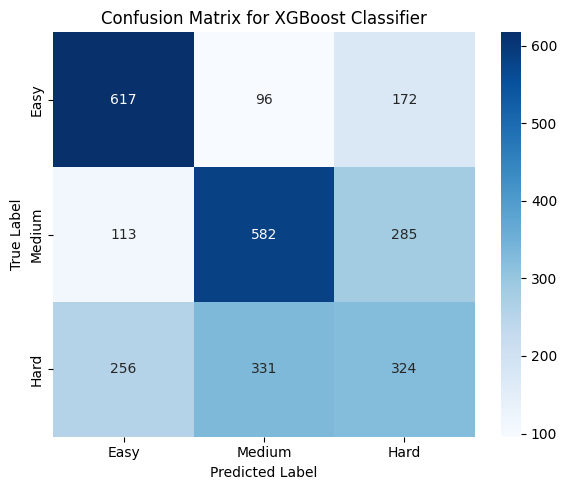

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class labels (VERY IMPORTANT: must match training order)
labels = ["Easy", "Medium", "Hard"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost Classifier")
plt.tight_layout()
plt.show()


In [ ]:
import joblib
import json

joblib.dump(tfidf, "C:/Users/asus/Desktop/ACM/models/tfidf.joblib")
joblib.dump(scaler, "C:/Users/asus/Desktop/ACM/models/scaler.joblib")
joblib.dump(xgb_clf, "C:/Users/asus/Desktop/ACM/models/xgb_clf.joblib")

meta = {
    "feature_cols": feature_cols,
}
with open("C:/Users/asus/Desktop/ACM/models/meta.json", "w") as f:
    json.dump(meta, f)
